In [1]:
%%javascript

    window.load_remote_theme = false;
    window.theme_url = "https://drostehk.github.io/ipynb-theme/";
    window.asset_url = "https://raw.githubusercontent.com/tijptjik/DS_assets/master/";

    window.load_local_theme = function(){
        var hostname = document.location.hostname
        return ((hostname == "localhost" || hostname == '127.0.0.1') && !load_remote_theme)
    }

    var url = load_local_theme() ? document.location.origin + "/files/theme/custom.js" : theme_url + 'custom.js'

    $.getScript(url)

<IPython.core.display.Javascript object>

# Random Forests

> see the forest for the trees

<footer>~ proverb</footer>

![break](assets/agenda.png)

1. Ensemble Techniques
1. Problems In Classification
1. Bagging
1. Boosting
1. Implementing Random Forests

**Labs:**
1. Random Forests

![break](assets/theory.png)

## Ensemble methods

Ensemble methods are learning algorithms that construct a set of classfiers and then classify new data points by taking a (weighted) vote of their predictions. They are methods of improving classification accuracy by aggregating predictions over several base classifiers. Ensembles are often much more accurate than the base classifiers that compose them.

In order for an ensemble classifier to outperform a single base classifier (bc), two conditions must be met. The bc’s must be:
1. *accurate*: they must outperform random guessing ~ _low bias_
1. *diverse*: their misclassifications must occur on different training examples ~ _uncorrelated_

Ideally, the base classifiers would also be *unstable* to variations in the training set ~ _high variance_

![](assets/ensemble.png)

## Problems In Classification

In any supervised learning task, our goal is to make predictions of the
true classification function `f` by learning the classifier `h`.
There are three main problems that can prevent this:

### Statistical problem

If the amount of training data available is small, the base classifier
will have difficulty converging to $h$ . An ensemble classifier can mitigate this problem by “averaging out” base classifier predictions to improve convergence.

![](assets/statistical.png)

The true function $f$ is best approximated as an average of the base classifiers.

#### Computational problem

Even with sufficient training data, it may still be computationally
difficult to find the best classifier h. For example, if our base classifier is a decision tree, an exhaustive search of the hypothesis space of all possible classifiers is extremely complex (NP-complete).

Recall that this is why we used a heuristic algorithm (greedy search).

An ensemble composed of several BC’s with different starting points can provide a better approximation to f than any individual BC.

![](assets/computational.png)

The true function $f$ is often best approximated by using several starting points to explore the hypothesis space.

#### Representational problem

Sometimes $f$ cannot be expressed in terms of our hypothesis at all. To illustrate this, suppose we use a decision tree as our base classifier. A decision tree works by forming a rectilinear partition of the feature space.

![](assets/rectilinear.png)

But what if $f$ is a diagonal line? Then it cannot be represented by finitely many rectilinear segments, and therefore the true decision boundary cannot be obtained by a decision tree classifier. However, it may be still be possible to approximate $f$ or even to expand the space of representable functions using ensemble methods.

An ensemble of decision trees can approximate a diagonal decision boundary.

![](assets/approximation.png)

![](assets/representational.png)

Ensemble classifiers can be effective even if the true decision boundary lies outside the hypothesis space.

### Creating an Ensemble Prediction

![](assets/ensemblecreation.png)

There are several ways to generate base classifiers
* manipulating the training set
* manipulating the learning algorithm itself
* manipulating the output labels

## Manipulating the training set

These technique works especially well for unstable learning algorithms|algorithms whose output classifier undergoes major changes in response to small changes in the training data. Decision-tree, neural network, and rule learning algorithms are all unstable. Linear regression, nearest neighbor, and linear threshold algorithms are generally very stable.

### Bagging

Bagging (bootstrap aggregating) is a method that involves manipulating the training set by *resampling*. We learn $k$ base classifiers on $k$ different samples of training data. These samples are independently created by resampling the training data using uniform weights (eg, a *uniform sampling distribution*).

* Each training sample is the same size as the original training set.
* Resampling means that some training records may appear in a sample more than once, or even not at all.

The final prediction is made by taking a majority vote across bc’s.

Bagging reduces the variance in our generalization error by aggregating multiple base classifiers together (provided they satisfy our earlier requirements).

If the base classifier is stable, then the ensemble error is primarily due to bc bias, and bagging may not be effective. Since each sample of training data is equally likely, bagging is not very susceptible to overfitting with noisy data.

![](assets/bagging_ozone.png)

_But taking the average of 100 smoothers, each fitted to a subset of the original data set, we arrive at one bagged predictor (red line). Clearly, the mean is more stable and there is less overfit._

### sklearn.ensemble.BaggingClassifier

When random susets of the dataset are drawn as _random subsets of the samples_, the this algorithm is known as **Pasting**. If samples are _drawn with replacement_, then the method is known as **Bagging**. When random subsets of the dataset are drawn as _random subsets of the features_, then the method is known as **Random Subspaces**. Finally, when base estimators are built on _subsets of both samples and features_, then the method is known as **Random Patches**.

In [59]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

iris = datasets.load_iris()

ensemble = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                             bootstrap=True,
                             bootstrap_features=False,
                             n_estimators=21)
ensemble.fit(iris.data, iris.target)
ensemble.score(iris.data, iris.target)

1.0

Area Under Curve: 1.00


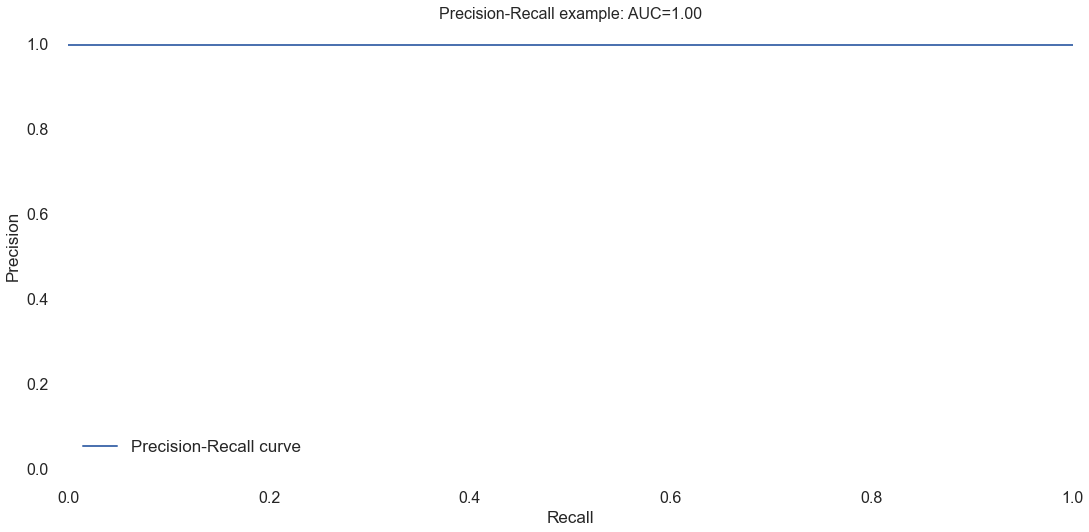

In [51]:
%matplotlib inline

import random
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn import metrics
from numpy import random

# Matplotlib Styles
mplc = {'axes.labelsize': 17,
'axes.titlesize': 16,
'figure.figsize': [18, 8],
'grid.linewidth': 1.6,
'legend.fontsize': 17,
'lines.linewidth': 2,
'lines.markeredgewidth': 0.0,
'lines.markersize': 11,
'patch.linewidth': 0.5,
'xtick.labelsize': 16,
'xtick.major.pad': 20,
'xtick.major.width': 2,
'xtick.minor.width': 1,
'ytick.labelsize': 16.0,
'ytick.major.pad': 20,
'ytick.major.width': 2,
'ytick.minor.width': 1 }

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]  # Keep also 2 classes (0 and 1)
n_samples, n_features = X.shape

p = range(n_samples)  # Shuffle samples
# 
random.seed(0)
random.shuffle(p)

X, y = X[p], y[p]
half = int(n_samples / 2)

# Add noisy features
np.random.seed(0)
X = np.c_[X, np.random.randn(n_samples, 200 * n_features)]

# Run classifier
probas_ = ensemble.fit(X[:half], y[:half]).predict_proba(X[half:])

# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(y[half:], probas_[:, 1])
area = auc(recall, precision)
print("Area Under Curve: %0.2f" % area)

with sns.plotting_context("talk", font_scale=1, rc=mplc):
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC=%0.2f' % area)
    plt.legend(loc="lower left")
    plt.show()

In [6]:
print metrics.classification_report(y[half:], ensemble.predict(X[half:]))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        24
          1       1.00      1.00      1.00        26

avg / total       1.00      1.00      1.00        50



![](assets/ensemble_boosting.jpg)

## Boosting

Boosting is an iterative procedure that adaptively changes the sampling distribution of training records at each iteration. The first iteration uses uniform weights (like bagging). In subsequent iterations, the weights are adjusted to emphasize records that were misclassified in previous iterations. The final prediction is constructed by a weighted vote (where the weights for a bc depends on its training error).

The bc’s focus more and more closely on records that are difficult to classify as the sequence of iterations progresses. Thus the bc’s are faced with progressively more difficult learning problems.

Like in bagging, sampling is done with replacement, and as a result some records may not appear in a given training sample. These omitted records will likely be misclassified, and given greater weight in subsequent iterations once the sampling distribution is updated. So even if a record is left out at one stage, it will be emphasized later.

Updating the sampling distribution and forming an ensemble prediction leads to a nonlinear combination of the base classifiers. By explicitly trying to optimize the weighted ensemble vote, boosting attacks the representation problem head-on.

In [4]:
from sklearn.ensemble import AdaBoostClassifier

ensemble = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ensemble.fit(iris.data, iris.target)
ensemble.score(iris.data, iris.target)

1.0

## Manipulating the learning algorithm itself

## Random Forests

A random forest is an ensemble of decision trees where each base classifier is grown using a random effect. One way to do this is to randomly choose one of the top $k$ features to split each node. For a small number of features, we can also create linear combinations of features and select splits from the enhanced feature set (Forest-RC). Or, we can select splitting features completely at random (Forest-RI).

Random forests are about as accurate as AdaBoost, more robust to noise, and can also have better runtime than other ensemble methods (since the feature space is reduced in some cases).

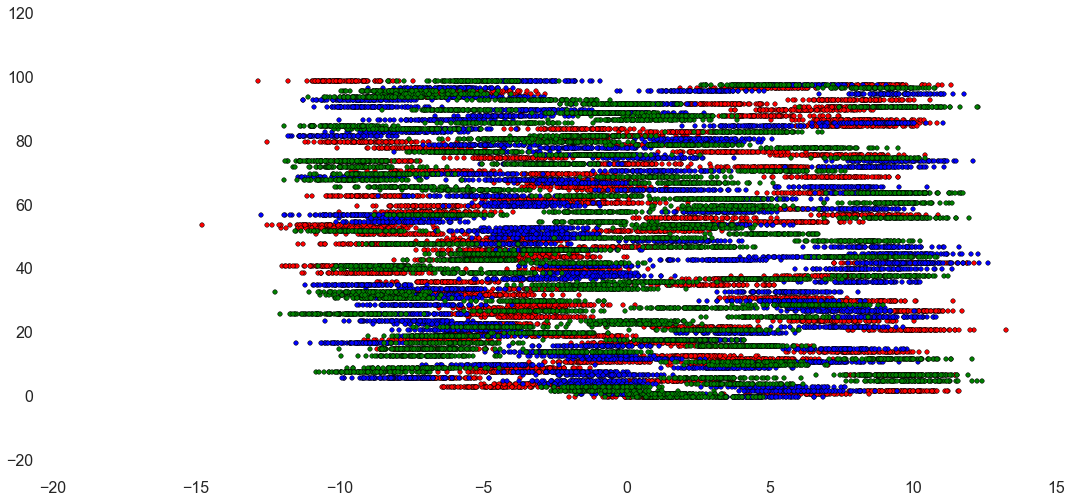

In [50]:
from IPython.display import display as dump

from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_blobs(n_samples=10000, n_features=10, centers=100,
     random_state=0)

with sns.plotting_context("talk", font_scale=1, rc=mplc):
    plt_x_1 = [x[0] for x in X]
    plt_x_2 = [x[1] for x in X]
    plt_x_3 = [x[2] for x in X]
    plt.scatter(plt_x_1, y, c='r')
    plt.scatter(plt_x_2, y ,c='b')
    plt.scatter(plt_x_3, y ,c='g')



In [34]:
## DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=1,
       random_state=0)
scores = cross_val_score(clf, X, y)
print "DecisionTreeClassifier:", scores.mean()

## RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=None,
     min_samples_split=1, random_state=0)
scores = cross_val_score(clf, X, y)
print "RandomForestClassifier:", scores.mean()

## ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None,
    min_samples_split=1, random_state=0)
scores = cross_val_score(clf, X, y)
print "ExtraTreesClassifier:  ", scores.mean()

DecisionTreeClassifier: 0.979408793821
RandomForestClassifier: 0.999607843137
ExtraTreesClassifier:   0.999898989899


The main parameters to adjust when using these methods is `n_estimators` and `max_features`. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are `max_features=n_features` for regression problems, and `max_features=sqrt(n_features)` for classification tasks (where `n_features` is the number of features in the data). The best results are also usually reached when setting `max_depth=None` in combination with `min_samples_split=1` (i.e., when fully developing the trees).

### Example Use Cases

* [Wisdom of Crowds](http://blog.factual.com/the-wisdom-of-crowds)
* [IBM’s WATSON](https://www.quora.com/Is-Watson-really-much-more-than-just-cramming-a-Google-index-into-a-standalone-supercomputer-combined-with-an-xtranormal-front-end?share=1)
* [Nate Silver’s election models](http://brandchannel.com/2012/11/07/math-we-can-believe-in-nate-silver-becomes-a-household-name/)
* [Kaggle competitions](https://www.kaggle.com/wiki/RandomForests)

![break](assets/code.png)

## Implementing Random Forests

Plot the decision surfaces of forests of randomized trees trained on pairs of features of the iris dataset.

This plot compares the decision surfaces learned by a decision tree classifier (first column), by a random forest classifier (second column), by an extra-trees classifier (third column) and by an AdaBoost classifier (fourth column).

In the first row, the classifiers are built using the sepal width and the sepal length features only, on the second row using the petal length and sepal length only, and on the third row using the petal width and the petal length only.

('DecisionTree with features', [0, 1], 'has a score of', 0.92666666666666664)
('RandomForest with 30 estimators with features', [0, 1], 'has a score of', 0.92666666666666664)
('ExtraTrees with 30 estimators with features', [0, 1], 'has a score of', 0.92666666666666664)
('AdaBoost with 30 estimators with features', [0, 1], 'has a score of', 0.85999999999999999)
('DecisionTree with features', [0, 2], 'has a score of', 0.99333333333333329)
('RandomForest with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('ExtraTrees with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('AdaBoost with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('DecisionTree with features', [2, 3], 'has a score of', 0.99333333333333329)
('RandomForest with 30 estimators with features', [2, 3], 'has a score of', 0.99333333333333329)
('ExtraTrees with 30 estimators with features', [2, 3], 'has a score of', 0.99333333333333329)
('Ad

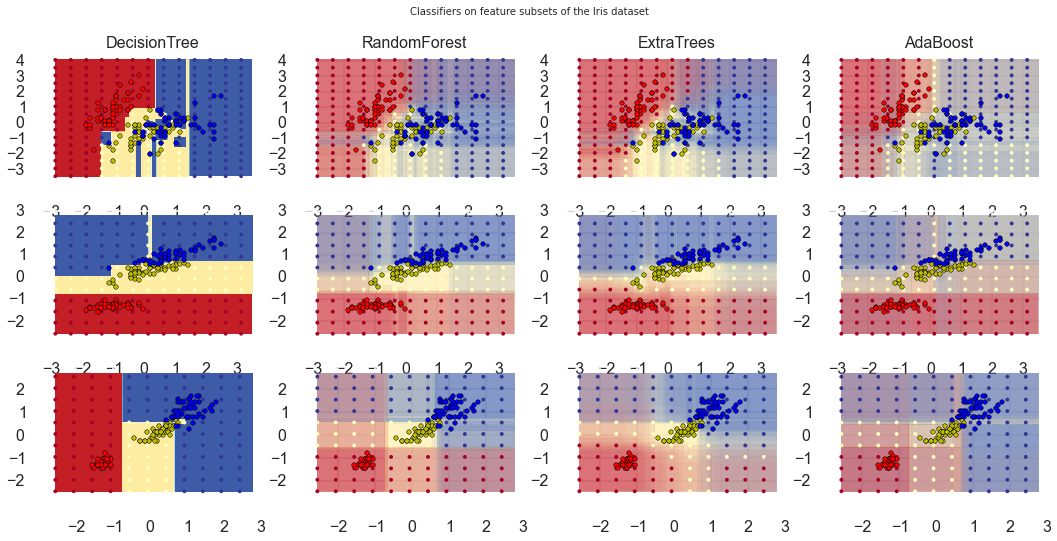

In [52]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]


with sns.plotting_context("talk", font_scale=1, rc=mplc):


    for pair in ([0, 1], [0, 2], [2, 3]):
        for model in models:
            # We only take the two corresponding features
            X = iris.data[:, pair]
            y = iris.target

            # Shuffle
            idx = np.arange(X.shape[0])
            np.random.seed(RANDOM_SEED)
            np.random.shuffle(idx)
            X = X[idx]
            y = y[idx]

            # Standardize
            mean = X.mean(axis=0)
            std = X.std(axis=0)
            X = (X - mean) / std

            # Train
            clf = clone(model)
            clf = model.fit(X, y)

            scores = clf.score(X, y)
            # Create a title for each column and the console by using str() and
            # slicing away useless parts of the string
            model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
            model_details = model_title
            if hasattr(model, "estimators_"):
                model_details += " with {} estimators".format(len(model.estimators_))
            print( model_details + " with features", pair, "has a score of", scores )

            plt.subplot(3, 4, plot_idx)
            if plot_idx <= len(models):
                # Add a title at the top of each column
                plt.title(model_title)

            # Now plot the decision boundary using a fine mesh as input to a
            # filled contour plot
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                                 np.arange(y_min, y_max, plot_step))

            # Plot either a single DecisionTreeClassifier or alpha blend the
            # decision surfaces of the ensemble of classifiers
            if isinstance(model, DecisionTreeClassifier):
                Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, cmap=cmap)
            else:
                # Choose alpha blend level with respect to the number of estimators
                # that are in use (noting that AdaBoost can use fewer estimators
                # than its maximum if it achieves a good enough fit early on)
                estimator_alpha = 1.0 / len(model.estimators_)
                for tree in model.estimators_:
                    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                    Z = Z.reshape(xx.shape)
                    cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

            # Build a coarser grid to plot a set of ensemble classifications
            # to show how these are different to what we see in the decision
            # surfaces. These points are regularly space and do not have a black outline
            xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                                 np.arange(y_min, y_max, plot_step_coarser))
            Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
            cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

            # Plot the training points, these are clustered together and have a
            # black outline
            for i, c in zip(xrange(n_classes), plot_colors):
                idx = np.where(y == i)
                plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                            cmap=cmap)

            plot_idx += 1  # move on to the next plot in sequence

    plt.suptitle("Classifiers on feature subsets of the Iris dataset")
    plt.axis("tight")

    plt.show()

### Application to other data sets

Here we have a dataset of chapters from books and plays by specific authors, and their usages of stop words. Let's see how accurately a random forest can predict the author based on stop word usage.

In [11]:
import random
from pandas import read_csv
from sklearn.cross_validation import train_test_split
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn import metrics
from sklearn import preprocessing

authorship = read_csv('../data/authorship.csv')
authorship

,a,all,also,an,and,any,are,as,at,be,...,what,when,which,who,will,with,would,your,BookID,Author
0,46,12,0,3,66,9,4,16,13,13,...,7,5,6,8,4,9,1,0,1,Austen
1,35,10,0,7,44,4,3,18,16,9,...,5,7,7,3,5,14,8,0,1,Austen
2,46,2,0,3,40,1,13,11,9,23,...,10,4,6,4,5,15,3,9,1,Austen
3,40,7,0,4,64,3,3,20,13,20,...,3,6,10,5,3,22,4,3,1,Austen
4,29,5,0,6,52,5,14,17,6,16,...,8,4,13,2,4,21,10,0,1,Austen
5,27,8,0,3,42,2,15,11,14,12,...,7,1,7,6,3,18,4,5,1,Austen
6,34,8,0,15,44,2,6,16,14,11,...,4,4,2,4,9,11,6,4,1,Austen
7,38,6,1,2,67,3,6,17,4,21,...,2,3,4,6,7,15,3,5,1,Austen
8,34,12,0,5,50,2,8,7,13,7,...,8,7,6,1,2,13,12,5,1,Austen
9,54,8,0,6,44,4,8,13,17,14,...,7,1,6,3,5,15,6,2,1,Austen


In [21]:
authors = list(set(authorship.Author.values))
print authors

['Austen', 'London', 'Shakespeare', 'Milton']


In [22]:
le = preprocessing.LabelEncoder()
le.fit(authors)
authorship['Author_num'] = le.transform(authorship['Author'])
print authorship['Author_num']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
...
826    3
827    3
828    3
829    3
830    3
831    3
832    3
833    3
834    3
835    3
836    3
837    3
838    3
839    3
840    3
Name: Author_num, Length: 841, dtype: int64


In [23]:
# Create a random variable (random forests work best with a random variable)
authorship['random'] = [random.random() for i in range(841)]

In [24]:
#What are some of the stop words we're looking at?
features = list(authorship.columns)
features.remove('Author')
features.remove('Author_num')
features.remove('BookID')
print features

['a', 'all', 'also', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', 'do', 'down', 'even', 'every', 'for', 'from', 'had', 'has', 'have', 'her', 'his', 'if', 'in', 'into', 'is', 'it', 'its', 'may', 'more', 'must', 'my', 'no', 'not', 'now', 'of', 'on', 'one', 'only', 'or', 'our', 'should', 'so', 'some', 'such', 'than', 'that', 'the', 'their', 'then', 'there', 'things', 'this', 'to', 'up', 'upon', 'was', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'would', 'your', 'random']


In [25]:
# create a test and training set
x_train, x_test, y_train, y_test = train_test_split(authorship[features], authorship.Author_num.values, test_size=0.4, random_state=123)
x, y = authorship[features], authorship.Author_num.values

In [26]:
# Fit Model
from sklearn.cross_validation import cross_val_score

etclf = ExtraTreesClassifier(n_estimators=20)
etclf.fit(x_train, y_train)

scores = cross_val_score(etclf, x, y)
print scores.mean()

# Print Confusion Matrix
print metrics.confusion_matrix(etclf.predict(x_test), y_test)
print authors

0.971554943522
[[135   0   0   0]
 [  1  99   0   1]
 [  0   0  20   0]
 [  0   0   0  81]]
['Austen', 'London', 'Shakespeare', 'Milton']


### Classwork

1. With the authorship data, determine how changing the parameters in the random forest model changes the performance of the model.

2. Also with the authorship data, feel free to go back to the base random forest classifer included in sklearn, or see how using adaboost does on guess work.

3. Try [timing](http://nbviewer.ipython.org/gist/anonymous/5978528) adaboost in comparison to randomforests to see how performance changes.

4. Consider building your own bagging algorithm (or get crazy and see if you can write up a simple boosting one) on your own. While this is relatively efficient in python, R users tend to complain a lot about how slow ensemble methods are (from the base packages). Building a strong understanding of these approaches can really move you along in the world of machine learning!

5. How can ensemble methods be distributed across a cluster of servers? Can they be?

![break](assets/resources.png)

## Resources

- [Random Forests in Python](http://blog.yhathq.com/posts/random-forests-in-python.html)
- [Random Forests for Kaggle](http://www.kaggle.com/c/titanic-gettingStarted/details/getting-started-with-random-forests)
- [Random Forests and Performance Metrics](http://citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics/)

### Academic

* [Original paper on Random Forests](http://oz.berkeley.edu/~breiman/randomforest2001.pdf)
* [Ensemble Methods in Machine Learning](http://www.ensemblemethods.com/documents/EnsembleMethodsInMachineLearning.pdf)
* [Explaining Bagging](ftp://stat.ethz.ch/Research-Reports/92.pdf)

### Modules

* [sklearn.ensemble.BaggingClassifier](http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.BaggingClassifier.html)